In [22]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

In [23]:
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 50
latent_dim = 2
hidden_dim = 256

In [24]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [25]:
# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

60000

In [26]:
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)
len(test_data)

10000

In [27]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [7]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

In [8]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.

        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z), scale_tril=torch.eye(z.shape[-1])
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

In [9]:
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 469,268


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [10]:
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [11]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [12]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)
        
        # Log embeddings
        z = output.z_sample
        writer.add_embedding(z, metadata=data, global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [13]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 543.9613 (Recon: 543.7311, KL: 0.2302) Grad: 20.0066
Step 100 (N samples: 12,800), Loss: 194.9288 (Recon: 190.9405, KL: 3.9883) Grad: 18.1698
Step 200 (N samples: 25,600), Loss: 177.9540 (Recon: 172.9229, KL: 5.0312) Grad: 88.4861
Step 300 (N samples: 38,400), Loss: 172.2797 (Recon: 167.4956, KL: 4.7841) Grad: 56.1199
Step 400 (N samples: 51,200), Loss: 172.3090 (Recon: 167.6286, KL: 4.6804) Grad: 47.3729


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.6334 (BCE: 166.1377, KLD: 4.4957)
Epoch 2/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 500 (N samples: 64,000), Loss: 170.3129 (Recon: 165.7859, KL: 4.5270) Grad: 23.6235
Step 600 (N samples: 76,800), Loss: 173.9133 (Recon: 169.2361, KL: 4.6772) Grad: 68.4605
Step 700 (N samples: 89,600), Loss: 170.5348 (Recon: 165.6880, KL: 4.8468) Grad: 56.2873
Step 800 (N samples: 102,400), Loss: 160.7663 (Recon: 155.8055, KL: 4.9607) Grad: 43.9446
Step 900 (N samples: 115,200), Loss: 163.5530 (Recon: 158.6932, KL: 4.8598) Grad: 29.4368


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 162.8280 (BCE: 157.6694, KLD: 5.1586)
Epoch 3/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,000 (N samples: 128,000), Loss: 168.6208 (Recon: 163.8961, KL: 4.7247) Grad: 44.9591
Step 1,100 (N samples: 140,800), Loss: 160.1515 (Recon: 155.2767, KL: 4.8748) Grad: 36.8925
Step 1,200 (N samples: 153,600), Loss: 159.8261 (Recon: 154.9036, KL: 4.9225) Grad: 65.7326
Step 1,300 (N samples: 166,400), Loss: 159.4723 (Recon: 154.0643, KL: 5.4080) Grad: 27.3420
Step 1,400 (N samples: 179,200), Loss: 159.4200 (Recon: 154.1163, KL: 5.3037) Grad: 59.0198


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 159.4399 (BCE: 154.3131, KLD: 5.1268)
Epoch 4/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,500 (N samples: 192,000), Loss: 158.4591 (Recon: 153.3639, KL: 5.0952) Grad: 42.6911
Step 1,600 (N samples: 204,800), Loss: 164.8301 (Recon: 159.5141, KL: 5.3160) Grad: 77.3673
Step 1,700 (N samples: 217,600), Loss: 160.2864 (Recon: 154.7502, KL: 5.5362) Grad: 62.2196
Step 1,800 (N samples: 230,400), Loss: 158.9115 (Recon: 153.4874, KL: 5.4241) Grad: 68.1701


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 155.4289 (BCE: 149.9646, KLD: 5.4643)
Epoch 5/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,900 (N samples: 243,200), Loss: 156.3146 (Recon: 150.5871, KL: 5.7275) Grad: 42.6244
Step 2,000 (N samples: 256,000), Loss: 154.3863 (Recon: 148.8277, KL: 5.5586) Grad: 78.6064
Step 2,100 (N samples: 268,800), Loss: 156.1646 (Recon: 150.2270, KL: 5.9376) Grad: 91.7925
Step 2,200 (N samples: 281,600), Loss: 151.9314 (Recon: 146.3243, KL: 5.6072) Grad: 145.4302
Step 2,300 (N samples: 294,400), Loss: 154.9077 (Recon: 149.2181, KL: 5.6896) Grad: 70.8381


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 152.7136 (BCE: 147.0833, KLD: 5.6304)
Epoch 6/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,400 (N samples: 307,200), Loss: 151.3106 (Recon: 145.5843, KL: 5.7263) Grad: 72.6470
Step 2,500 (N samples: 320,000), Loss: 149.5426 (Recon: 143.6147, KL: 5.9279) Grad: 55.3069
Step 2,600 (N samples: 332,800), Loss: 150.2429 (Recon: 144.2396, KL: 6.0033) Grad: 60.7760
Step 2,700 (N samples: 345,600), Loss: 158.6037 (Recon: 152.5170, KL: 6.0867) Grad: 74.8550
Step 2,800 (N samples: 358,400), Loss: 155.6744 (Recon: 149.8475, KL: 5.8269) Grad: 61.5395


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 151.0822 (BCE: 145.3015, KLD: 5.7808)
Epoch 7/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,900 (N samples: 371,200), Loss: 157.5251 (Recon: 151.6089, KL: 5.9162) Grad: 72.6742
Step 3,000 (N samples: 384,000), Loss: 138.3240 (Recon: 132.2763, KL: 6.0477) Grad: 102.7774
Step 3,100 (N samples: 396,800), Loss: 146.4338 (Recon: 140.5427, KL: 5.8911) Grad: 88.3594
Step 3,200 (N samples: 409,600), Loss: 155.6416 (Recon: 149.7850, KL: 5.8566) Grad: 55.6334


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 149.4759 (BCE: 143.3296, KLD: 6.1463)
Epoch 8/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,300 (N samples: 422,400), Loss: 151.0655 (Recon: 144.8682, KL: 6.1972) Grad: 110.8075
Step 3,400 (N samples: 435,200), Loss: 152.7961 (Recon: 146.7010, KL: 6.0951) Grad: 118.5462
Step 3,500 (N samples: 448,000), Loss: 143.0393 (Recon: 136.7205, KL: 6.3188) Grad: 94.6928
Step 3,600 (N samples: 460,800), Loss: 144.3466 (Recon: 138.1032, KL: 6.2434) Grad: 83.5842
Step 3,700 (N samples: 473,600), Loss: 146.4897 (Recon: 140.2616, KL: 6.2281) Grad: 121.6832


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 148.4372 (BCE: 142.3864, KLD: 6.0509)
Epoch 9/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,800 (N samples: 486,400), Loss: 153.4308 (Recon: 147.3578, KL: 6.0731) Grad: 112.6172
Step 3,900 (N samples: 499,200), Loss: 147.9928 (Recon: 141.9491, KL: 6.0437) Grad: 72.7960
Step 4,000 (N samples: 512,000), Loss: 143.9255 (Recon: 137.6752, KL: 6.2504) Grad: 126.7928
Step 4,100 (N samples: 524,800), Loss: 151.3178 (Recon: 145.1455, KL: 6.1723) Grad: 112.8174
Step 4,200 (N samples: 537,600), Loss: 157.1779 (Recon: 151.2118, KL: 5.9661) Grad: 112.9789


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 147.1427 (BCE: 141.0726, KLD: 6.0701)
Epoch 10/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4,300 (N samples: 550,400), Loss: 153.2276 (Recon: 147.0358, KL: 6.1917) Grad: 106.1619
Step 4,400 (N samples: 563,200), Loss: 151.6066 (Recon: 145.4442, KL: 6.1624) Grad: 79.5528
Step 4,500 (N samples: 576,000), Loss: 150.0728 (Recon: 143.8564, KL: 6.2164) Grad: 112.3010
Step 4,600 (N samples: 588,800), Loss: 144.0129 (Recon: 137.4272, KL: 6.5858) Grad: 64.1611


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 146.5022 (BCE: 140.3046, KLD: 6.1976)
Epoch 11/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4,700 (N samples: 601,600), Loss: 145.2102 (Recon: 139.0141, KL: 6.1961) Grad: 131.3283
Step 4,800 (N samples: 614,400), Loss: 147.1269 (Recon: 140.9223, KL: 6.2046) Grad: 65.7017
Step 4,900 (N samples: 627,200), Loss: 133.9196 (Recon: 127.5536, KL: 6.3660) Grad: 88.8623
Step 5,000 (N samples: 640,000), Loss: 137.9888 (Recon: 131.5591, KL: 6.4297) Grad: 182.7781
Step 5,100 (N samples: 652,800), Loss: 142.6365 (Recon: 136.3220, KL: 6.3146) Grad: 105.6285


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 145.8438 (BCE: 139.6561, KLD: 6.1877)
Epoch 12/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5,200 (N samples: 665,600), Loss: 149.6689 (Recon: 143.3862, KL: 6.2827) Grad: 106.1502
Step 5,300 (N samples: 678,400), Loss: 144.5997 (Recon: 138.1298, KL: 6.4699) Grad: 77.6271
Step 5,400 (N samples: 691,200), Loss: 146.9307 (Recon: 140.4978, KL: 6.4329) Grad: 129.8399
Step 5,500 (N samples: 704,000), Loss: 149.1219 (Recon: 142.6124, KL: 6.5095) Grad: 223.3713
Step 5,600 (N samples: 716,800), Loss: 145.2182 (Recon: 138.8637, KL: 6.3545) Grad: 97.0542


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 146.0065 (BCE: 139.8237, KLD: 6.1828)
Epoch 13/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5,700 (N samples: 729,600), Loss: 143.8389 (Recon: 137.3039, KL: 6.5350) Grad: 117.5256
Step 5,800 (N samples: 742,400), Loss: 153.2472 (Recon: 146.9639, KL: 6.2833) Grad: 85.9351
Step 5,900 (N samples: 755,200), Loss: 143.3083 (Recon: 137.0341, KL: 6.2741) Grad: 102.2401
Step 6,000 (N samples: 768,000), Loss: 144.9481 (Recon: 138.4312, KL: 6.5170) Grad: 96.9675


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 145.3017 (BCE: 138.9585, KLD: 6.3432)
Epoch 14/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6,100 (N samples: 780,800), Loss: 152.2618 (Recon: 145.8427, KL: 6.4191) Grad: 68.2349
Step 6,200 (N samples: 793,600), Loss: 149.0948 (Recon: 142.8264, KL: 6.2684) Grad: 74.2405
Step 6,300 (N samples: 806,400), Loss: 152.9223 (Recon: 146.8367, KL: 6.0857) Grad: 219.5308
Step 6,400 (N samples: 819,200), Loss: 148.9525 (Recon: 142.6235, KL: 6.3290) Grad: 144.2473
Step 6,500 (N samples: 832,000), Loss: 139.6137 (Recon: 133.1441, KL: 6.4696) Grad: 97.8829


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.5116 (BCE: 138.0100, KLD: 6.5016)
Epoch 15/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6,600 (N samples: 844,800), Loss: 137.6916 (Recon: 131.1739, KL: 6.5178) Grad: 82.0049
Step 6,700 (N samples: 857,600), Loss: 144.7086 (Recon: 138.2614, KL: 6.4472) Grad: 163.8807
Step 6,800 (N samples: 870,400), Loss: 138.1070 (Recon: 131.7599, KL: 6.3471) Grad: 158.4933
Step 6,900 (N samples: 883,200), Loss: 148.9813 (Recon: 142.4637, KL: 6.5176) Grad: 120.7579
Step 7,000 (N samples: 896,000), Loss: 144.0966 (Recon: 137.6917, KL: 6.4049) Grad: 78.9503


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.1832 (BCE: 137.7329, KLD: 6.4503)
Epoch 16/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7,100 (N samples: 908,800), Loss: 147.1603 (Recon: 140.8684, KL: 6.2918) Grad: 75.0866
Step 7,200 (N samples: 921,600), Loss: 146.0900 (Recon: 139.5857, KL: 6.5042) Grad: 205.5933
Step 7,300 (N samples: 934,400), Loss: 145.5098 (Recon: 139.0596, KL: 6.4502) Grad: 150.8817
Step 7,400 (N samples: 947,200), Loss: 140.2247 (Recon: 133.8469, KL: 6.3778) Grad: 131.7920
Step 7,500 (N samples: 960,000), Loss: 145.0154 (Recon: 138.4008, KL: 6.6146) Grad: 73.7319


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 143.7117 (BCE: 137.2465, KLD: 6.4652)
Epoch 17/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7,600 (N samples: 972,800), Loss: 134.9940 (Recon: 128.4214, KL: 6.5727) Grad: 81.4156
Step 7,700 (N samples: 985,600), Loss: 141.5484 (Recon: 134.7097, KL: 6.8388) Grad: 235.5273
Step 7,800 (N samples: 998,400), Loss: 146.1524 (Recon: 139.8623, KL: 6.2901) Grad: 129.6011
Step 7,900 (N samples: 1,011,200), Loss: 147.6440 (Recon: 141.3710, KL: 6.2730) Grad: 129.7736


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.0723 (BCE: 137.7728, KLD: 6.2996)
Epoch 18/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8,000 (N samples: 1,024,000), Loss: 144.7931 (Recon: 138.3434, KL: 6.4497) Grad: 132.0062
Step 8,100 (N samples: 1,036,800), Loss: 149.9553 (Recon: 143.4513, KL: 6.5040) Grad: 91.4192
Step 8,200 (N samples: 1,049,600), Loss: 143.8167 (Recon: 137.4300, KL: 6.3867) Grad: 83.9077
Step 8,300 (N samples: 1,062,400), Loss: 143.9419 (Recon: 137.7056, KL: 6.2364) Grad: 216.0544
Step 8,400 (N samples: 1,075,200), Loss: 136.8099 (Recon: 130.2624, KL: 6.5474) Grad: 142.8998


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 143.4279 (BCE: 136.8751, KLD: 6.5528)
Epoch 19/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8,500 (N samples: 1,088,000), Loss: 138.3225 (Recon: 131.8944, KL: 6.4282) Grad: 56.8993
Step 8,600 (N samples: 1,100,800), Loss: 134.6504 (Recon: 128.0973, KL: 6.5531) Grad: 112.2404
Step 8,700 (N samples: 1,113,600), Loss: 146.2071 (Recon: 139.6953, KL: 6.5119) Grad: 213.3115
Step 8,800 (N samples: 1,126,400), Loss: 139.9799 (Recon: 133.4620, KL: 6.5179) Grad: 140.5173
Step 8,900 (N samples: 1,139,200), Loss: 146.1870 (Recon: 139.6488, KL: 6.5382) Grad: 101.2792


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 143.2556 (BCE: 136.7482, KLD: 6.5074)
Epoch 20/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,000 (N samples: 1,152,000), Loss: 144.0385 (Recon: 137.7151, KL: 6.3234) Grad: 117.9044
Step 9,100 (N samples: 1,164,800), Loss: 144.0899 (Recon: 137.3857, KL: 6.7042) Grad: 197.2568
Step 9,200 (N samples: 1,177,600), Loss: 145.1873 (Recon: 138.7408, KL: 6.4465) Grad: 91.7161
Step 9,300 (N samples: 1,190,400), Loss: 138.9220 (Recon: 132.3644, KL: 6.5576) Grad: 183.9009


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.9333 (BCE: 136.4582, KLD: 6.4751)
Epoch 21/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,400 (N samples: 1,203,200), Loss: 148.3692 (Recon: 141.7585, KL: 6.6107) Grad: 160.8879
Step 9,500 (N samples: 1,216,000), Loss: 149.4904 (Recon: 143.0128, KL: 6.4776) Grad: 206.8200
Step 9,600 (N samples: 1,228,800), Loss: 140.9119 (Recon: 134.3357, KL: 6.5762) Grad: 109.7124
Step 9,700 (N samples: 1,241,600), Loss: 143.0484 (Recon: 136.6354, KL: 6.4130) Grad: 159.9668
Step 9,800 (N samples: 1,254,400), Loss: 149.1608 (Recon: 142.4147, KL: 6.7461) Grad: 91.6165


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.7564 (BCE: 136.2521, KLD: 6.5043)
Epoch 22/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,900 (N samples: 1,267,200), Loss: 136.5196 (Recon: 129.8980, KL: 6.6216) Grad: 154.8706
Step 10,000 (N samples: 1,280,000), Loss: 142.0770 (Recon: 135.6152, KL: 6.4618) Grad: 154.1062
Step 10,100 (N samples: 1,292,800), Loss: 140.5328 (Recon: 133.8864, KL: 6.6464) Grad: 119.1951
Step 10,200 (N samples: 1,305,600), Loss: 139.7398 (Recon: 133.1018, KL: 6.6380) Grad: 133.0356
Step 10,300 (N samples: 1,318,400), Loss: 143.1515 (Recon: 136.5681, KL: 6.5834) Grad: 129.6968


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.8076 (BCE: 136.2365, KLD: 6.5711)
Epoch 23/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10,400 (N samples: 1,331,200), Loss: 135.5358 (Recon: 128.9708, KL: 6.5649) Grad: 95.2441
Step 10,500 (N samples: 1,344,000), Loss: 141.6390 (Recon: 135.0143, KL: 6.6247) Grad: 93.8372
Step 10,600 (N samples: 1,356,800), Loss: 143.6667 (Recon: 137.1521, KL: 6.5146) Grad: 102.9237
Step 10,700 (N samples: 1,369,600), Loss: 137.3878 (Recon: 130.8402, KL: 6.5477) Grad: 122.7867


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.1252 (BCE: 135.5785, KLD: 6.5466)
Epoch 24/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10,800 (N samples: 1,382,400), Loss: 147.4346 (Recon: 140.9240, KL: 6.5105) Grad: 127.2836
Step 10,900 (N samples: 1,395,200), Loss: 143.5322 (Recon: 136.9703, KL: 6.5620) Grad: 150.9512
Step 11,000 (N samples: 1,408,000), Loss: 145.4646 (Recon: 138.6712, KL: 6.7935) Grad: 126.6333
Step 11,100 (N samples: 1,420,800), Loss: 136.8147 (Recon: 130.3396, KL: 6.4752) Grad: 61.2854
Step 11,200 (N samples: 1,433,600), Loss: 146.0408 (Recon: 139.4121, KL: 6.6288) Grad: 106.0872


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.0160 (BCE: 135.5204, KLD: 6.4956)
Epoch 25/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11,300 (N samples: 1,446,400), Loss: 141.9232 (Recon: 135.3457, KL: 6.5774) Grad: 152.6807
Step 11,400 (N samples: 1,459,200), Loss: 148.1514 (Recon: 141.6149, KL: 6.5365) Grad: 158.5126
Step 11,500 (N samples: 1,472,000), Loss: 143.5287 (Recon: 137.2122, KL: 6.3165) Grad: 131.2398
Step 11,600 (N samples: 1,484,800), Loss: 149.4953 (Recon: 143.0126, KL: 6.4827) Grad: 181.5352
Step 11,700 (N samples: 1,497,600), Loss: 144.7888 (Recon: 138.3090, KL: 6.4798) Grad: 160.1836


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.5347 (BCE: 135.9259, KLD: 6.6088)
Epoch 26/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11,800 (N samples: 1,510,400), Loss: 138.3668 (Recon: 131.8259, KL: 6.5409) Grad: 147.3313
Step 11,900 (N samples: 1,523,200), Loss: 138.6882 (Recon: 132.0886, KL: 6.5996) Grad: 138.2765
Step 12,000 (N samples: 1,536,000), Loss: 135.5203 (Recon: 128.7702, KL: 6.7501) Grad: 128.6851
Step 12,100 (N samples: 1,548,800), Loss: 141.6959 (Recon: 135.1061, KL: 6.5897) Grad: 134.7590


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.3459 (BCE: 135.7862, KLD: 6.5597)
Epoch 27/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12,200 (N samples: 1,561,600), Loss: 141.5383 (Recon: 134.9103, KL: 6.6279) Grad: 106.6556
Step 12,300 (N samples: 1,574,400), Loss: 143.4422 (Recon: 136.8761, KL: 6.5661) Grad: 120.4618
Step 12,400 (N samples: 1,587,200), Loss: 143.7028 (Recon: 137.1616, KL: 6.5412) Grad: 158.3643
Step 12,500 (N samples: 1,600,000), Loss: 142.9812 (Recon: 136.4105, KL: 6.5707) Grad: 125.6290
Step 12,600 (N samples: 1,612,800), Loss: 140.8642 (Recon: 134.2613, KL: 6.6029) Grad: 172.4699


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.7110 (BCE: 135.2073, KLD: 6.5037)
Epoch 28/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12,700 (N samples: 1,625,600), Loss: 147.2059 (Recon: 140.6681, KL: 6.5379) Grad: 94.0791
Step 12,800 (N samples: 1,638,400), Loss: 145.9362 (Recon: 139.5680, KL: 6.3681) Grad: 129.5959
Step 12,900 (N samples: 1,651,200), Loss: 145.8337 (Recon: 139.2179, KL: 6.6158) Grad: 110.5826
Step 13,000 (N samples: 1,664,000), Loss: 141.0467 (Recon: 134.5048, KL: 6.5419) Grad: 84.2543
Step 13,100 (N samples: 1,676,800), Loss: 146.0853 (Recon: 139.2247, KL: 6.8606) Grad: 97.5998


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.3467 (BCE: 134.6962, KLD: 6.6504)
Epoch 29/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13,200 (N samples: 1,689,600), Loss: 138.7638 (Recon: 132.0964, KL: 6.6673) Grad: 141.4968
Step 13,300 (N samples: 1,702,400), Loss: 140.4070 (Recon: 133.7350, KL: 6.6719) Grad: 130.3626
Step 13,400 (N samples: 1,715,200), Loss: 151.9002 (Recon: 145.5145, KL: 6.3857) Grad: 132.7759
Step 13,500 (N samples: 1,728,000), Loss: 138.8337 (Recon: 132.1306, KL: 6.7031) Grad: 187.7993
Step 13,600 (N samples: 1,740,800), Loss: 148.5199 (Recon: 141.8346, KL: 6.6853) Grad: 107.1304


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.3265 (BCE: 134.7497, KLD: 6.5768)
Epoch 30/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13,700 (N samples: 1,753,600), Loss: 142.6626 (Recon: 136.1051, KL: 6.5575) Grad: 194.0352
Step 13,800 (N samples: 1,766,400), Loss: 141.8636 (Recon: 135.1566, KL: 6.7069) Grad: 146.9616
Step 13,900 (N samples: 1,779,200), Loss: 143.2028 (Recon: 136.4280, KL: 6.7748) Grad: 120.2049
Step 14,000 (N samples: 1,792,000), Loss: 134.8265 (Recon: 128.0327, KL: 6.7938) Grad: 109.2665


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.4043 (BCE: 134.7788, KLD: 6.6256)
Epoch 31/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14,100 (N samples: 1,804,800), Loss: 140.2503 (Recon: 133.4756, KL: 6.7746) Grad: 126.7213
Step 14,200 (N samples: 1,817,600), Loss: 141.9748 (Recon: 135.0362, KL: 6.9386) Grad: 121.5284
Step 14,300 (N samples: 1,830,400), Loss: 143.0220 (Recon: 136.3581, KL: 6.6639) Grad: 88.7703
Step 14,400 (N samples: 1,843,200), Loss: 139.6707 (Recon: 133.0600, KL: 6.6107) Grad: 177.3362
Step 14,500 (N samples: 1,856,000), Loss: 143.8407 (Recon: 137.1125, KL: 6.7282) Grad: 202.9152


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.2782 (BCE: 134.5704, KLD: 6.7078)
Epoch 32/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14,600 (N samples: 1,868,800), Loss: 143.0225 (Recon: 136.2326, KL: 6.7899) Grad: 86.2944
Step 14,700 (N samples: 1,881,600), Loss: 143.7103 (Recon: 137.0913, KL: 6.6190) Grad: 107.7915
Step 14,800 (N samples: 1,894,400), Loss: 133.3280 (Recon: 126.6814, KL: 6.6466) Grad: 159.2086
Step 14,900 (N samples: 1,907,200), Loss: 139.4702 (Recon: 132.8942, KL: 6.5760) Grad: 162.4932
Step 15,000 (N samples: 1,920,000), Loss: 135.9105 (Recon: 129.3423, KL: 6.5682) Grad: 91.2644


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.1999 (BCE: 134.5075, KLD: 6.6925)
Epoch 33/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15,100 (N samples: 1,932,800), Loss: 139.2454 (Recon: 132.7141, KL: 6.5314) Grad: 205.7171
Step 15,200 (N samples: 1,945,600), Loss: 133.7741 (Recon: 127.0217, KL: 6.7524) Grad: 106.3935
Step 15,300 (N samples: 1,958,400), Loss: 134.6694 (Recon: 128.1302, KL: 6.5392) Grad: 119.3465
Step 15,400 (N samples: 1,971,200), Loss: 148.3640 (Recon: 141.8901, KL: 6.4739) Grad: 100.8156


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.8877 (BCE: 134.1831, KLD: 6.7046)
Epoch 34/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15,500 (N samples: 1,984,000), Loss: 142.6074 (Recon: 136.0566, KL: 6.5507) Grad: 93.9035
Step 15,600 (N samples: 1,996,800), Loss: 136.4413 (Recon: 129.5450, KL: 6.8962) Grad: 111.1289
Step 15,700 (N samples: 2,009,600), Loss: 138.5651 (Recon: 131.9799, KL: 6.5852) Grad: 150.5768


KeyboardInterrupt: 

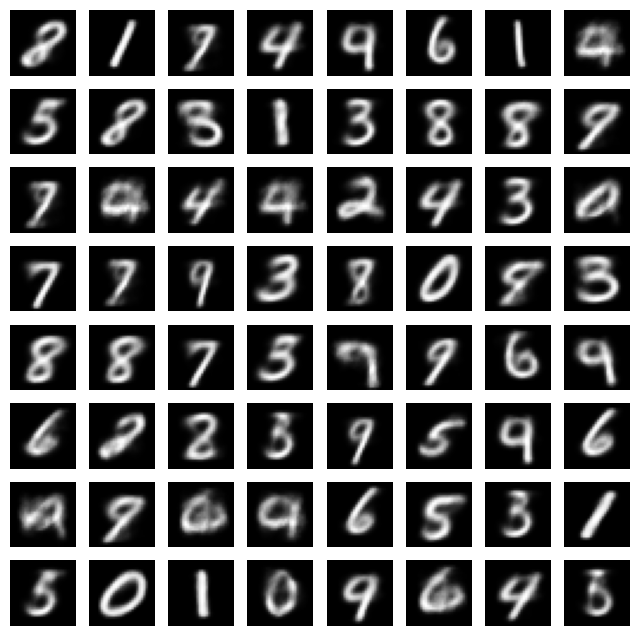

In [14]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

plt.show()